In [3]:
# !pip install torch

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("rocities.txt", "r").read().splitlines()
words[:10]

['1 DECEMBRIE',
 '2 MAI',
 '23 AUGUST',
 'ABRAM',
 'ABRAMUT',
 'ABRUD',
 'ABRUD-SAT',
 'ABUCEA',
 'ABUD',
 'ABUS']

In [4]:
len(words)

10148

In [6]:
# build the vocabulary and mappings to/from ints
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i,s in enumerate(chars)}
stoi['*'] = 0
itos = {i: s for s,i in stoi.items()}
print(stoi)
chars_count = len(stoi.values())

{' ': 1, '-': 2, '.': 3, '1': 4, '2': 5, '3': 6, 'A': 7, 'B': 8, 'C': 9, 'D': 10, 'E': 11, 'F': 12, 'G': 13, 'H': 14, 'I': 15, 'J': 16, 'K': 17, 'L': 18, 'M': 19, 'N': 20, 'O': 21, 'P': 22, 'R': 23, 'S': 24, 'T': 25, 'U': 26, 'V': 27, 'X': 28, 'Y': 29, 'Z': 30, '*': 0}


In [55]:
# dataset

block_size = 3 # length of context: no. of characters we use to predict the next

X, Y = [], []
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '*':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix] # crop and append, like a rolling window
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [56]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([98696, 3]), torch.int64, torch.Size([98696]), torch.int64)

In [10]:
chars_count

31

In [7]:
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([78812, 3]) torch.Size([78812])
torch.Size([9972, 3]) torch.Size([9972])
torch.Size([9912, 3]) torch.Size([9912])


In [11]:
C = torch.randn((chars_count, 2))  # lookup table - each char is 2 dimensional

In [13]:
emb = C[X]
emb.shape

torch.Size([42, 3, 2])

In [14]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [15]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [16]:
h

tensor([[ 0.9534,  0.9526, -0.9999,  ...,  0.3725,  0.8822,  0.9132],
        [ 0.9981,  0.9784, -1.0000,  ...,  0.8397,  0.9609,  0.9558],
        [-0.9837,  0.9834, -0.9677,  ...,  0.9980, -0.6042,  0.5047],
        ...,
        [ 0.9984, -0.1281, -0.9944,  ..., -0.9721, -0.4807,  0.0122],
        [ 0.8547,  0.7818, -0.9986,  ...,  0.9968, -0.9415,  0.9750],
        [-0.8325,  1.0000, -0.9164,  ...,  0.9927,  0.6431,  0.6123]])

In [18]:
h.shape

torch.Size([42, 100])

In [27]:
W2 = torch.randn((100, chars_count))
b2 = torch.randn(chars_count)

In [28]:
logits = h @ W2 + b2

In [29]:
logits.shape

torch.Size([42, 31])

In [24]:
counts = logits.exp()

In [25]:
prob = counts / counts.sum(1, keepdims=True)

In [26]:
prob.shape

torch.Size([42, 27])

In [31]:
loss = -prob[torch.arange(42), Y].log().mean()
loss

tensor(17.4903)

In [33]:
# ======== Refactor ========

In [107]:
Xtr.shape, Ytr.shape

(torch.Size([78934, 3]), torch.Size([78934]))

In [8]:
g = torch.Generator().manual_seed(21)  # for reproductibility
C = torch.randn((chars_count, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, chars_count), generator=g)
b2 = torch.randn(chars_count, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters)  # total number of parameters

12741

In [94]:
emb = C[X]  # [42, 3, 2]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2  # (42, 31)
loss = F.cross_entropy(logits, Y)

In [95]:
loss

tensor(19.8123)

In [10]:
for p in parameters:
    p.requires_grad = True

In [11]:
lre = torch.linspace(-3, 0, 30000)
lrs = 10**lre

In [12]:
lri = []
lossi = []
stepi = []

In [19]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (42,))
    
    # forward pass
    emb = C[Xtr[ix]]  # [42, 3, 2]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2  # (42, 31)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)

print(loss.item())

1.730530023574829


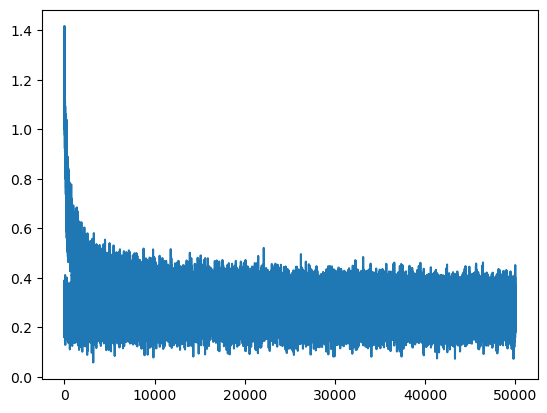

In [20]:
plt.plot(stepi, lossi)

In [21]:
emb = C[Xtr]  # [42, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2  # (42, 31)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.8481, grad_fn=<NllLossBackward0>)

In [22]:
emb = C[Xdev]  # [42, 3, 2]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2  # (42, 31)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.9461, grad_fn=<NllLossBackward0>)

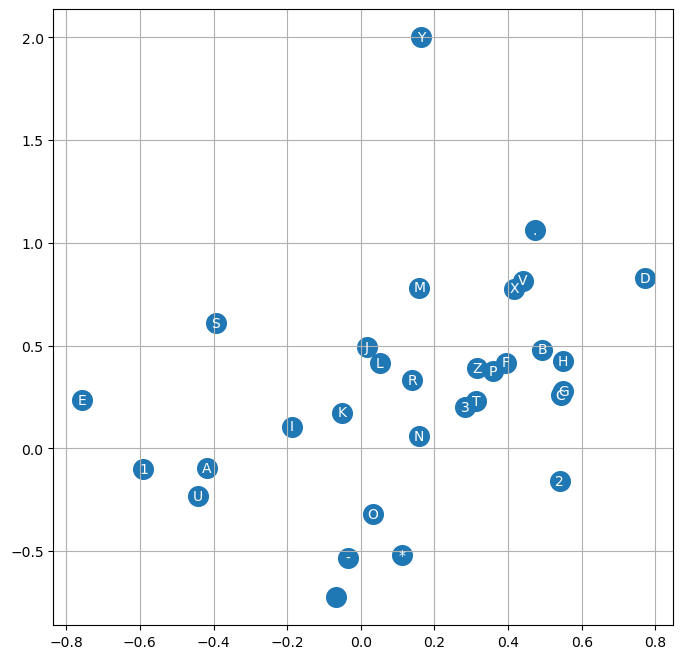

In [141]:
# visualize the character embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')